In [17]:
from __future__ import division
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn as sk
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
import warnings # to silence convergence warnings
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import missingno as msno

from functions import *

import math


sns.set() # Set searborn as default

%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

## Load data

In [127]:
df_initial = pd.read_csv('./case1Data.txt',delimiter=',',header=0, na_values=[' NaN'])
df = df_initial.copy()


## Missing values

<Axes: >

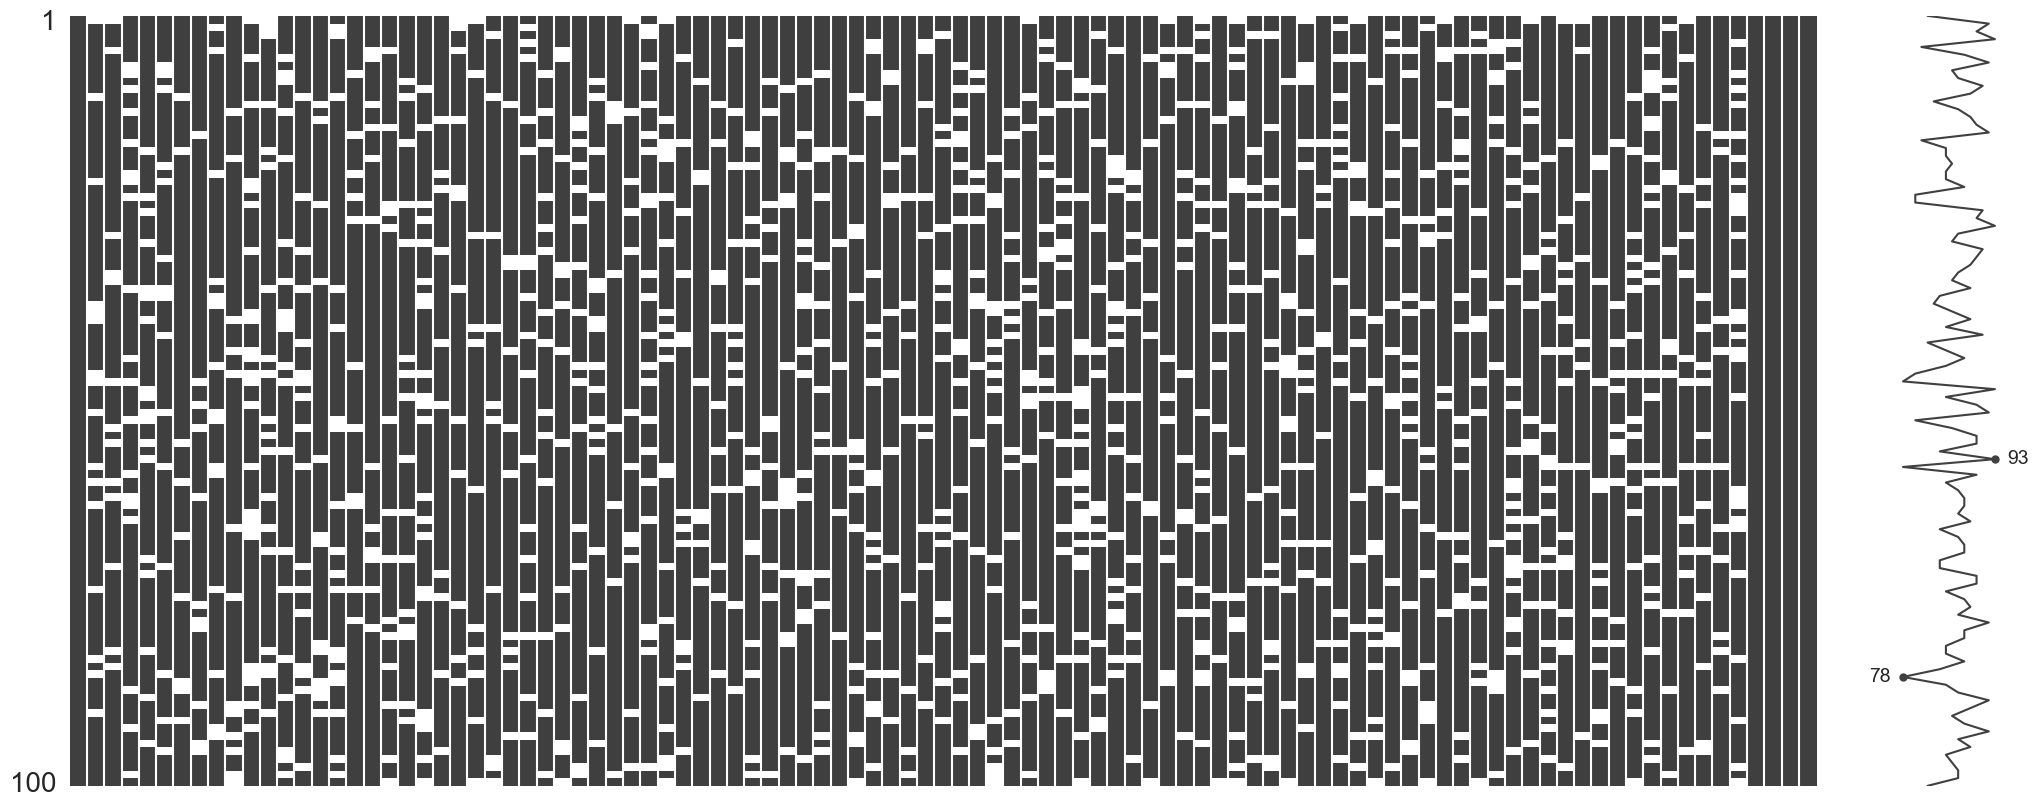

In [3]:
msno.matrix(df)

## Model selection

1.-Before missing values:(100, 101)
2.-After missing values:(100, 101)
3.-After categorical values:(100, 117)
Variables generated:Index([' x_95', ' C_ 1_ G', ' C_ 1_ H', ' C_ 1_ I', ' C_ 1_ J', ' C_ 1_ K',
       ' C_ 2_ H', ' C_ 3_ G', ' C_ 3_ H', ' C_ 3_ I', ' C_ 3_ J', ' C_ 3_ K',
       ' C_ 4_ G', ' C_ 4_ H', ' C_ 4_ I', ' C_ 4_ J', ' C_ 4_ K', ' C_ 5_ G',
       ' C_ 5_ H', ' C_ 5_ I', ' C_ 5_ J', ' C_ 5_ K'],
      dtype='object')


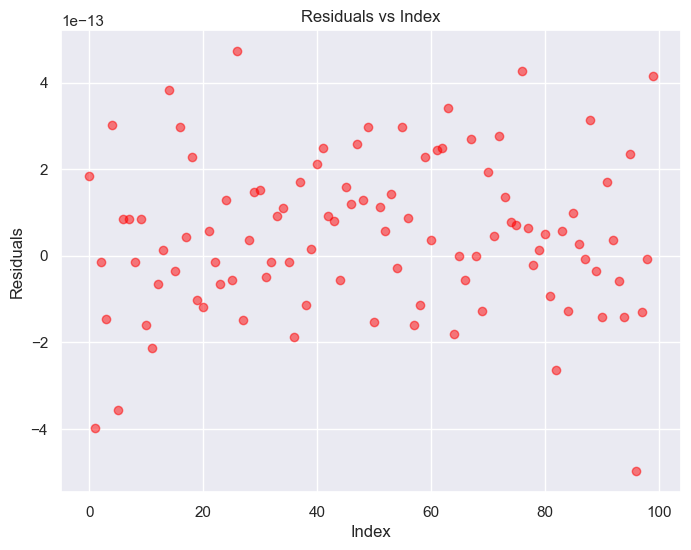

In [48]:
d = df_initial.copy()


d = preprocessing(d)

y = d.iloc[:,0].to_numpy()
X = d.iloc[:,1:].to_numpy()

beta, error, rank, eigenval = np.linalg.lstsq(X.astype('float'), y, rcond=None)
yhat = X @ beta

residuals = (y - yhat)


# Alternatively, plot residuals against the index of data points
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y)), residuals, color='red', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Residuals vs Index')
plt.grid(True)
plt.show()


### OLS  with CV

[[ 25.839023   9.687474  -3.978178 ...   0.         1.         0.      ]
 [ 26.204958  11.185962  -8.247602 ...   0.         0.         0.      ]
 [ 18.560873  11.355342  -9.370161 ...   0.         0.         0.      ]
 ...
 [ 27.160523  10.134287 -10.920363 ...   0.         1.         0.      ]
 [ 20.391153  10.18032  -11.469746 ...   0.         0.         0.      ]
 [ 23.061566   6.863659 -11.654218 ...   1.         0.         0.      ]]


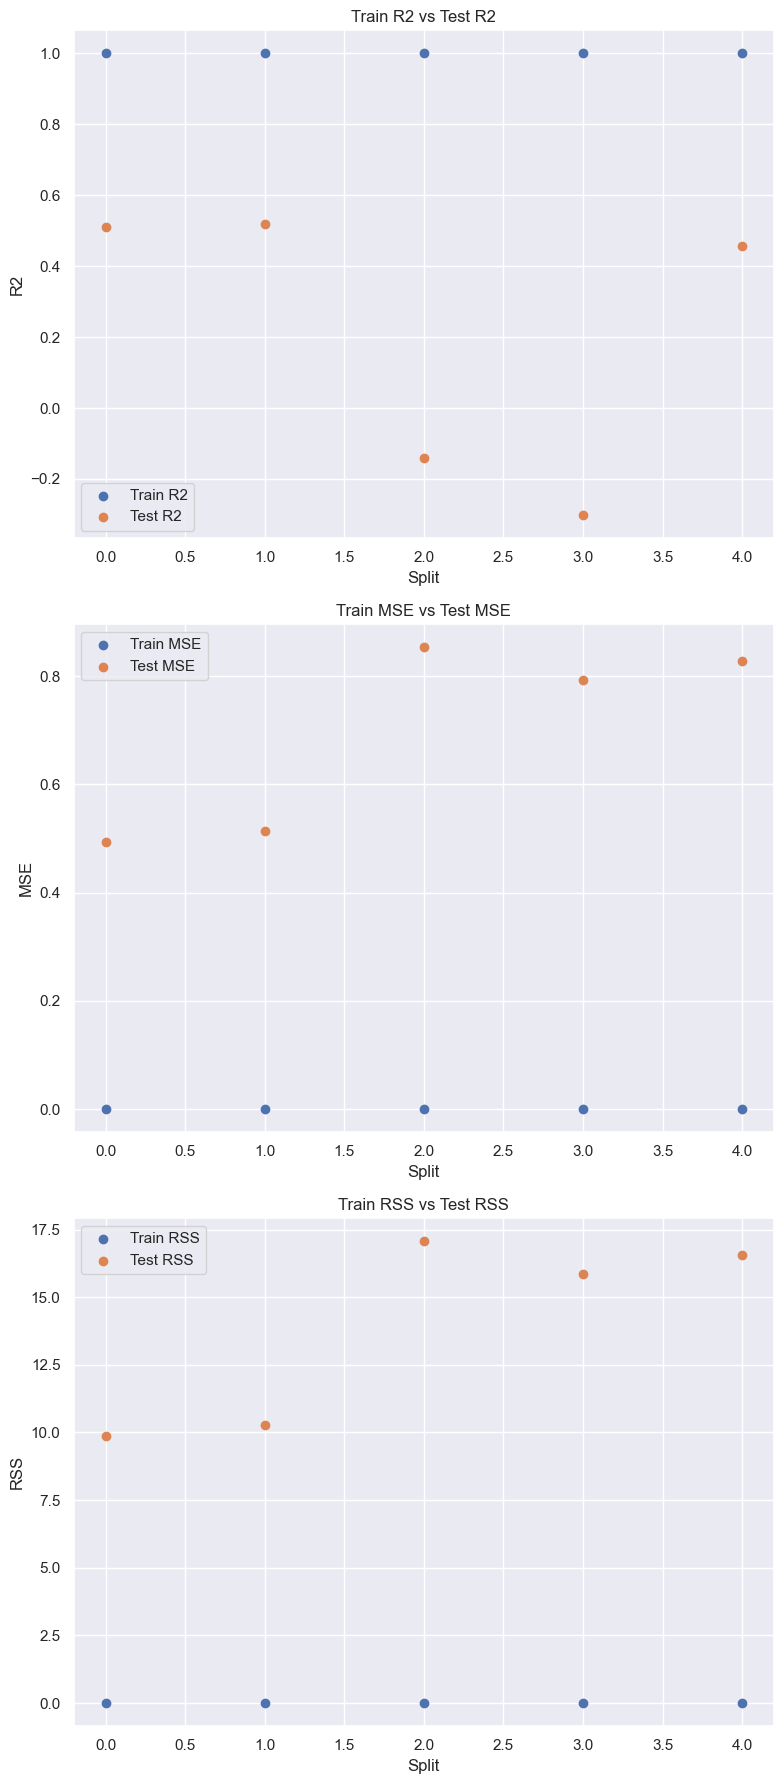

In [130]:

data = df_initial.copy()
data_OLS = df_initial.copy()

 # preserves all the information and its a simple transformation so it should not lead to any data leakage

data_OLS = handle_categorical_values(data_OLS)
data_OLS = handle_missing_values(data_OLS)

y = data_OLS.iloc[:,0].to_numpy()
X = data_OLS.iloc[:,1:].to_numpy()

#First attempt without CV

beta, error, rank, eigenval = np.linalg.lstsq(X.astype('float'), y, rcond=None)
yhat  = X @ beta

MSE_OLS = MSE(y,yhat) #We will use this as the estimator for the residual variance


data = handle_categorical_values(data)

y = data.iloc[:,0]
X = data.iloc[:,1:]


K = 5
CV = KFold(n_splits=K,shuffle=True)
X_standardizer = StandardScaler()

train_RSS = [0]*K
test_RSS = [0]*K
train_R2 = [0]*K
test_R2 = [0]*K
train_MSE = [0]*K
test_MSE = [0]*K
train_TSS = [0]*K
test_TSS = [0]*K

for i, (train_index, test_index) in enumerate(CV.split(X,y)):

    # Deal with missing values 

   

    X_train  = X.iloc[train_index,:]
    Y_train  = y.iloc[train_index]
    X_test   = X.iloc[test_index,:]
    Y_test   = y.iloc[test_index]

    X_train = handle_missing_values(X_train)
    X_test  = handle_missing_values(X_test)


    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    Y_train = Y_train.to_numpy()
    Y_test = Y_test.to_numpy()
    # Normalization


    X_train = X_standardizer.fit_transform(X_train)
    X_test = X_standardizer.transform(X_test)

    Y_train = X_standardizer.fit_transform(Y_train.reshape(-1,1))
    Y_test = X_standardizer.transform(Y_test.reshape(-1,1))


    
    beta, error, rank, eigenval = np.linalg.lstsq(X_train.astype('float'), Y_train, rcond=None)
    yhat_test  = X_test @ beta
    yhat_train = X_train @ beta

    train_RSS[i]   = RSS(Y_train,yhat_train)
    test_RSS[i]    = RSS(Y_test,yhat_test)
    train_R2[i]    = R2(Y_train,yhat_train) 
    test_R2[i]     = R2(Y_test,yhat_test) 
    train_MSE[i]   = MSE(Y_train,yhat_train)
    test_MSE[i]    = MSE(Y_test,yhat_test)
    test_TSS[i]    = TSS(Y_test)
    train_TSS[i]   = TSS(Y_train)

    

fig, axs = plt.subplots(3, 1, figsize=(8, 18))

# Plot (Train R2 and Test R2)
axs[0].scatter(range(K), train_R2, label='Train R2', marker='o')
axs[0].scatter(range(K), test_R2, label='Test R2', marker='o')
axs[0].set_title('Train R2 vs Test R2')
axs[0].set_xlabel('Split')
axs[0].set_ylabel('R2')
axs[0].legend()

# Plot (Train MSE and Test MSE)
axs[1].scatter(range(K), train_MSE, label='Train MSE', marker='o')
axs[1].scatter(range(K), test_MSE, label='Test MSE', marker='o')
axs[1].set_title('Train MSE vs Test MSE')
axs[1].set_xlabel('Split')
axs[1].set_ylabel('MSE')
axs[1].legend()

# Plot (Train RSS and Test RSS)
axs[2].scatter(range(K), train_RSS, label='Train RSS', marker='o')
axs[2].scatter(range(K), test_RSS, label='Test RSS', marker='o')
axs[2].set_title('Train RSS vs Test RSS')
axs[2].set_xlabel('Split')
axs[2].set_ylabel('RSS')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()





### OLS_ridge with CV


1.-Before missing values:(100, 116)
2.-After missing values:(100, 116)
3.-After categorical values:(100, 116)
Variables generated:Index([' C_ 1_ G', ' C_ 1_ H', ' C_ 1_ I', ' C_ 1_ J', ' C_ 1_ K', ' C_ 2_ H',
       ' C_ 3_ G', ' C_ 3_ H', ' C_ 3_ I', ' C_ 3_ J', ' C_ 3_ K', ' C_ 4_ G',
       ' C_ 4_ H', ' C_ 4_ I', ' C_ 4_ J', ' C_ 4_ K', ' C_ 5_ G', ' C_ 5_ H',
       ' C_ 5_ I', ' C_ 5_ J', ' C_ 5_ K'],
      dtype='object')


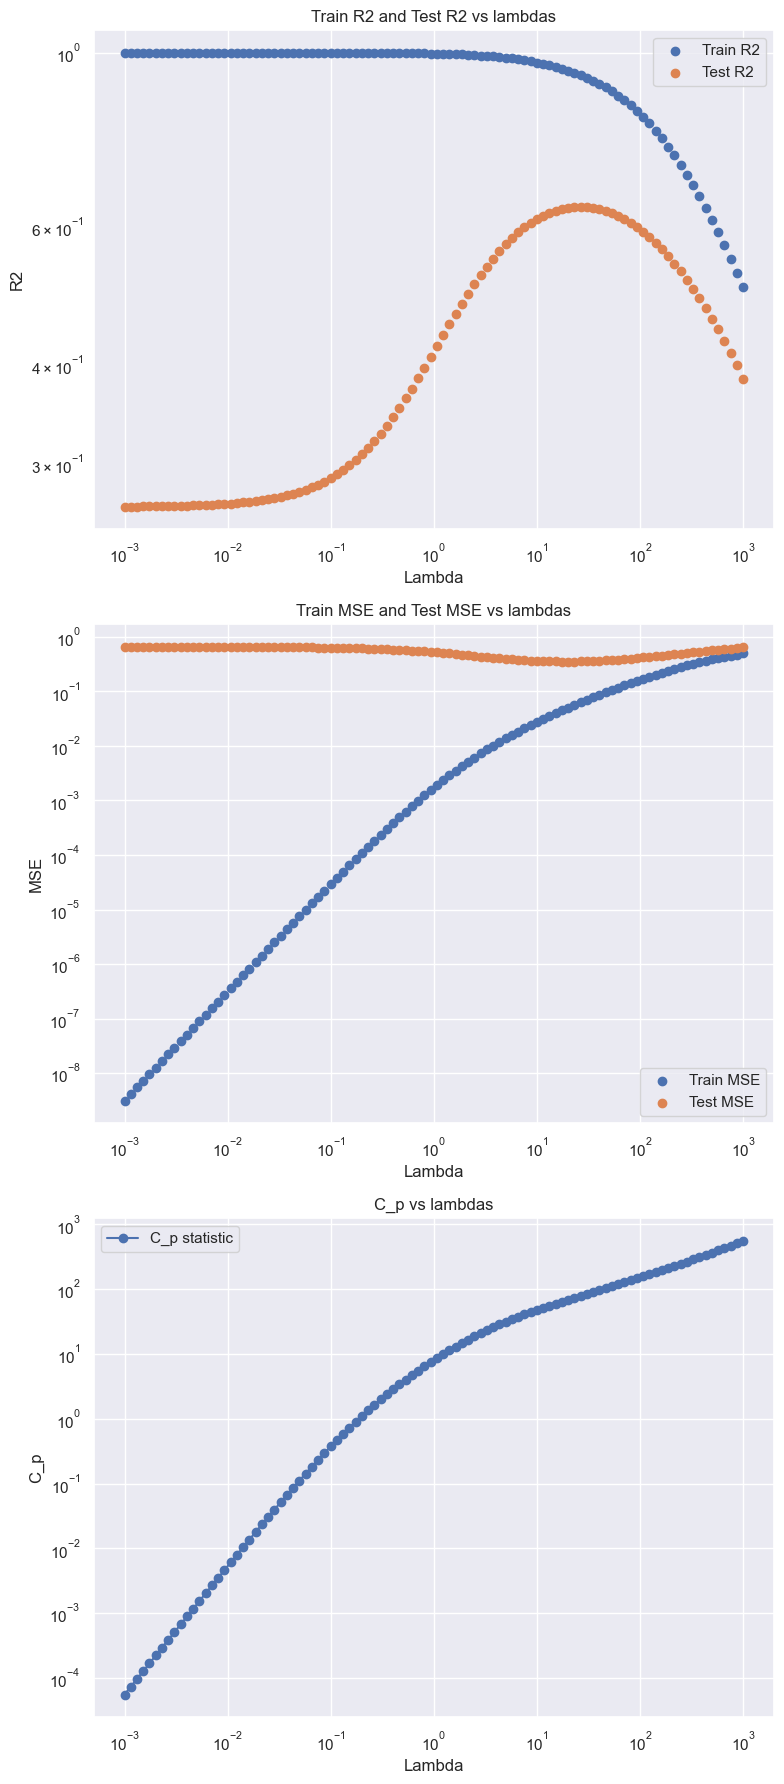

In [154]:
data = df_initial.copy()

data = handle_categorical_values(data) # preserves all the information and its a simple transformation so it should not lead to any data leakage

amp = 3
n_v = 100; # try n values of lambda
lambdas = np.logspace(-amp, amp, n)


y = data.iloc[:,0]
X = data.iloc[:,1:]

y_ols = data.iloc[:,0]
X_ols = data.iloc[:,1:]

X_ols = preprocessing(X_ols).to_numpy()
y_ols = y_ols.to_numpy()


K = 5
CV = KFold(n_splits=K,shuffle=True)
X_standardizer = StandardScaler()

train_R2    = np.zeros((n_v,K))
test_R2     = np.zeros((n_v,K))
train_MSE   = np.zeros((n_v,K))
test_MSE    = np.zeros((n_v,K))

mean_train_R2      = np.zeros(n_v) 
mean_test_R2       = np.zeros(n_v) 
mean_train_MSE     = np.zeros(n_v)
mean_test_MSE      = np.zeros(n_v)




for i, (train_index, test_index) in enumerate(CV.split(X,y)):

    # Deal with missing values

    X_train  = X.iloc[train_index,:]
    Y_train  = y.iloc[train_index]
    X_test   = X.iloc[test_index,:]
    Y_test   = y.iloc[test_index]

    X_train = handle_missing_values(X_train)
    X_test  = handle_missing_values(X_test)


    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    Y_train = Y_train.to_numpy()
    Y_test = Y_test.to_numpy()
    # Normalization


    X_train = X_standardizer.fit_transform(X_train)
    X_test = X_standardizer.transform(X_test)

    Y_train = X_standardizer.fit_transform(Y_train.reshape(-1,1))
    Y_test = X_standardizer.transform(Y_test.reshape(-1,1))

    #Now in this block we just run ridge with every possible varible
    
    for j,l in enumerate(lambdas):


        #Fit model 
        p = np.shape(X_train)[1]
        I = np.identity(p)
        inner_prod = np.linalg.inv(X_train.T @ X_train + l * np.eye(p,p))
        outer_prod = X_train.T @ Y_train
        betas = inner_prod @ outer_prod

        #Predict
        yhat_test = X_test @ betas
        yhat_train= X_train@ betas

        train_R2    [j][i]      = R2(Y_train,yhat_train)[0]
        test_R2     [j][i]      = R2(Y_test,yhat_test)[0] 
        train_MSE   [j][i]      = MSE(Y_train,yhat_train)[0]
        test_MSE    [j][i]      = MSE(Y_test,yhat_test)[0]
    

for u in range(n_v):
    mean_train_R2[u]    = np.mean(train_R2[u])
    mean_test_R2[u]     = np.mean(test_R2[u])
    mean_train_MSE[u]   = np.mean(train_MSE[u])
    mean_test_MSE[u]    = np.mean(test_MSE[u])
    

#Cp statistic
Cp = np.zeros(n_v)
[n,p] = np.shape(X_ols)
n_features = len(X.columns)
#betas = np.zeros(p,n_v)
for i,l in enumerate(lambdas):
    p = np.shape(X)[1]
    I = np.identity(p)
    
    inner_prod = np.linalg.inv(X_ols.T @ X_ols + l * np.eye(p,p))
    outer_prod = X_ols.T @ y_ols
    betas = inner_prod @ outer_prod
    yhat = X_ols @ betas
    Cp[i] = np.mean(((y-yhat)**2)) + 2*n_features/n*MSE_OLS



fig, axs = plt.subplots(3, 1, figsize=(8, 18))

# Plot (Train R2 and Test R2)
axs[0].scatter(lambdas, mean_train_R2, label='Train R2', marker='o')
axs[0].scatter(lambdas, mean_test_R2, label='Test R2', marker='o')
axs[0].set_title('Train R2 and Test R2 vs lambdas')
axs[0].set_xlabel('Lambda')
axs[0].set_ylabel('R2')
axs[0].legend()
axs[0].set_xscale('log')
axs[0].set_yscale('log')

# Plot (Train MSE and Test MSE)
axs[1].scatter(lambdas, mean_train_MSE, label='Train MSE', marker='o')
axs[1].scatter(lambdas, mean_test_MSE, label='Test MSE', marker='o')
axs[1].set_title('Train MSE and Test MSE vs lambdas')
axs[1].set_xlabel('Lambda')
axs[1].set_ylabel('MSE')
axs[1].legend()
axs[1].set_xscale('log')
axs[1].set_yscale('log')


axs[2].plot(lambdas, Cp, label='C_p statistic', marker='o')
axs[2].set_title('C_p vs lambdas')
axs[2].set_xlabel('Lambda')
axs[2].set_ylabel('C_p')
axs[2].legend()
axs[2].set_xscale('log')
axs[2].set_yscale('log')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()






In [157]:
#Cp statistic tells us that this model is kinda bullshit => there is no collinearity between variables 

## Lasso with CV

In [ ]:
data = df_initial.copy()

data = handle_categorical_values(data) # preserves all the information and its a simple transformation so it should not lead to any data leakage

amp = 3
n_v = 100; # try n values of lambda
lambdas = np.logspace(-amp, amp, n)


y = data.iloc[:,0]
X = data.iloc[:,1:]

y_ols = data.iloc[:,0]
X_ols = data.iloc[:,1:]

X_ols = preprocessing(X_ols).to_numpy()
y_ols = y_ols.to_numpy()


K = 5
CV = KFold(n_splits=K,shuffle=True)
X_standardizer = StandardScaler()

train_R2    = np.zeros((n_v,K))
test_R2     = np.zeros((n_v,K))
train_MSE   = np.zeros((n_v,K))
test_MSE    = np.zeros((n_v,K))

mean_train_R2      = np.zeros(n_v) 
mean_test_R2       = np.zeros(n_v) 
mean_train_MSE     = np.zeros(n_v)
mean_test_MSE      = np.zeros(n_v)




for i, (train_index, test_index) in enumerate(CV.split(X,y)):

    # Deal with missing values

    X_train  = X.iloc[train_index,:]
    Y_train  = y.iloc[train_index]
    X_test   = X.iloc[test_index,:]
    Y_test   = y.iloc[test_index]

    X_train = handle_missing_values(X_train)
    X_test  = handle_missing_values(X_test)


    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    Y_train = Y_train.to_numpy()
    Y_test = Y_test.to_numpy()
    # Normalization


    X_train = X_standardizer.fit_transform(X_train)
    X_test = X_standardizer.transform(X_test)

    Y_train = X_standardizer.fit_transform(Y_train.reshape(-1,1))
    Y_test = X_standardizer.transform(Y_test.reshape(-1,1))

    #Now in this block we just run ridge with every possible varible
    
    for j,l in enumerate(lambdas):


        #Fit model 
        p = np.shape(X_train)[1]
        I = np.identity(p)
        inner_prod = np.linalg.inv(X_train.T @ X_train + l * np.eye(p,p))
        outer_prod = X_train.T @ Y_train
        betas = inner_prod @ outer_prod

        #Predict
        yhat_test = X_test @ betas
        yhat_train= X_train@ betas

        train_R2    [j][i]      = R2(Y_train,yhat_train)[0]
        test_R2     [j][i]      = R2(Y_test,yhat_test)[0] 
        train_MSE   [j][i]      = MSE(Y_train,yhat_train)[0]
        test_MSE    [j][i]      = MSE(Y_test,yhat_test)[0]
    

for u in range(n_v):
    mean_train_R2[u]    = np.mean(train_R2[u])
    mean_test_R2[u]     = np.mean(test_R2[u])
    mean_train_MSE[u]   = np.mean(train_MSE[u])
    mean_test_MSE[u]    = np.mean(test_MSE[u])
    

#Cp statistic
Cp = np.zeros(n_v)
[n,p] = np.shape(X_ols)
n_features = len(X.columns)
#betas = np.zeros(p,n_v)
for i,l in enumerate(lambdas):
    p = np.shape(X)[1]
    I = np.identity(p)
    
    inner_prod = np.linalg.inv(X_ols.T @ X_ols + l * np.eye(p,p))
    outer_prod = X_ols.T @ y_ols
    betas = inner_prod @ outer_prod
    yhat = X_ols @ betas
    Cp[i] = np.mean(((y-yhat)**2)) + 2*n_features/n*MSE_OLS



fig, axs = plt.subplots(3, 1, figsize=(8, 18))

# Plot (Train R2 and Test R2)
axs[0].scatter(lambdas, mean_train_R2, label='Train R2', marker='o')
axs[0].scatter(lambdas, mean_test_R2, label='Test R2', marker='o')
axs[0].set_title('Train R2 and Test R2 vs lambdas')
axs[0].set_xlabel('Lambda')
axs[0].set_ylabel('R2')
axs[0].legend()
axs[0].set_xscale('log')
axs[0].set_yscale('log')

# Plot (Train MSE and Test MSE)
axs[1].scatter(lambdas, mean_train_MSE, label='Train MSE', marker='o')
axs[1].scatter(lambdas, mean_test_MSE, label='Test MSE', marker='o')
axs[1].set_title('Train MSE and Test MSE vs lambdas')
axs[1].set_xlabel('Lambda')
axs[1].set_ylabel('MSE')
axs[1].legend()
axs[1].set_xscale('log')
axs[1].set_yscale('log')


axs[2].plot(lambdas, Cp, label='C_p statistic', marker='o')
axs[2].set_title('C_p vs lambdas')
axs[2].set_xlabel('Lambda')
axs[2].set_ylabel('C_p')
axs[2].legend()
axs[2].set_xscale('log')
axs[2].set_yscale('log')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()




